# **Week5 Part2: Object Localization  and Classification with custom data**

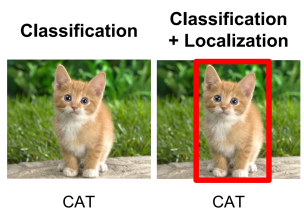

In [1]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# **Prepare Labels (class)**

*   Sigle class
*   Multi classes




In [2]:
# Catate class_map for multi calsses
class_map = {"plant":0, "weed":1, "Package":2}
num_class = 3
"""# Single class
class_map = {"plant":0}
num_class = 1"""

'# Single class\nclass_map = {"plant":0}\nnum_class = 1'

# **Read XML : Bounding Box + Class**

In [3]:
def parse_xml(xml_path, class_map):

    # Parse XML structure
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Read original size
    size = root.find("size")
    w = int(size.find("width").text)
    h = int(size.find("height").text)


    # Read Object calss and extract class name and class index
    object_name = root.find("object")
    class_name = object_name.find("name").text
    class_id = class_map[class_name]
    # Extract bounding box
    box = root.find("object").find("bndbox")
    xmin = int(box.find("xmin").text)
    ymin = int(box.find("ymin").text)
    xmax = int(box.find("xmax").text)
    ymax = int(box.find("ymax").text)

    # Nomalize bounding box
    bbox = [xmin / w, ymin / h, xmax / w, ymax / h]

    # Return bounding box and class id
    return bbox , class_id

# **Load images, bounding box annotations, and class labels**

In [4]:
def load_dataset(image_dir, xml_dir, class_map, img_size=224):
    # Add  labels list
    images, bboxes, labels = [], [], []

    for f in os.listdir(image_dir):
        if f.endswith(".jpg"):
            # Load image from disk
            img = cv2.imread(os.path.join(image_dir, f))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Resize image to match model input
            img = cv2.resize(img, (img_size, img_size))
            # Normalize image pixels
            img = img / 255.0

            # Parse bounding box and class label from XML
            # return bbox and label (class id)
            box, label = parse_xml(
                os.path.join(xml_dir, f.replace(".jpg", ".xml")),
                class_map #class_map
            )

            # Append image bboxes and labels to lists
            images.append(img)
            bboxes.append(box)
            labels.append(label)
    # Convert lists to Numpy array
    images = np.array(images)
    bboxes = np.array(bboxes)
    labels = np.array(labels)
    # Return data
    return images, bboxes, labels

# **Creating the Model for Multi-task Learning (Localization and Classification)**

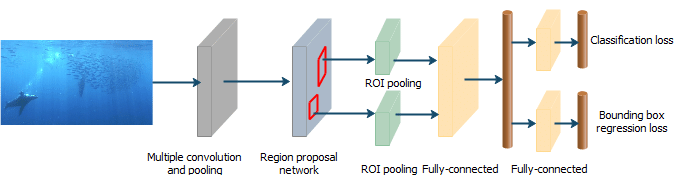

In [5]:
def build_cnn(NUM_CLASS):
    """ Custom CNN for join object localization and classification
        Output :
        >> Bounding box : xmin, ymin, xmax, ymax
        >> Class probability
    """

    # VGG15, MobileNetV2 ...
    base = tf.keras.applications.MobileNetV2(
        input_shape = (224, 224, 3),
        include_top = False,
        weights = "imagenet"
    )

    # Freeze the weights
    base.trainable = False

    # Custom the fully connected layers
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(1024, #hidden layer
                      activation="relu" #activation function #relu 
                      )(x)
    x = layers.Dense(520, activation="relu")(x)
    # Bounding box regression head
    bbox = layers.Dense(
        4, #last layer output 4 values
        activation="sigmoid", #normalize between 0 and 1
        name="bbox" #output layer name
        )(x)
    # Classification head
    class_probs = layers.Dense(
        NUM_CLASS, #NUM_CLASS
        activation="softmax" if NUM_CLASS > 1 else "sigmoid",#softmax for multi-classsigmoid for single-class
        name="class_probs" #output layer name
    )(x)
    # return outputs
    return models.Model(inputs=base.input, #model input
                        outputs=[bbox, class_probs] #model outputs
                        )

# **Load the training dataset**



1.   X : Input images
2.   y_bbox: Bounding box label -> xmin ymin ...
3. y_class: Integer class labels.





In [6]:
# Create training data from your drive using load_dataset().
X, y_bbox, y_class = load_dataset(
    image_dir=r"C:\Users\jinny\Desktop\cv\Package dataset\train",
    xml_dir=r"C:\Users\jinny\Desktop\cv\Package dataset\train",
    class_map=class_map,
)

In [7]:
print(f" bbox: \n {y_bbox[:5]} \n clsss lable:\n {y_class}")

 bbox: 
 [[0.53190104 0.69335938 0.61588542 0.77050781]
 [0.61523438 0.54345703 0.76627604 0.64111328]
 [0.28125    0.56542969 0.42252604 0.6484375 ]
 [0.13346354 0.52587891 0.4765625  0.80419922]
 [0.04622396 0.49365234 0.42578125 0.78222656]] 
 clsss lable:
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


# **Compile the model (Multi-loss)**

In [8]:
# Build CNN model
model = build_cnn(num_class)
model.summary()
# Compile molel
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = {
        "bbox": "mse",
        "class_probs": "sparse_categorical_crossentropy" if num_class > 1 else "binary_crossentropy",
    },
    metrics = {
        "bbox": "mae",
        "class_probs": "accuracy",
    }
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,106,375 (15.66 MB)

 Trainable params: 1,848,391 (7.05 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# **Train the model**

In [9]:
# model.fit()
model.fit(
    x = X,
    y = {
        "bbox": y_bbox,
        "class_probs": y_class,
    },
    epochs = 50,
    batch_size = 4,
    validation_split = 0.1
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - bbox_loss: 0.0775 - bbox_mae: 0.2376 - class_probs_accuracy: 1.0000 - class_probs_loss: 0.1006 - loss: 0.1781 - val_bbox_loss: 0.1138 - val_bbox_mae: 0.2970 - val_class_probs_accuracy: 1.0000 - val_class_probs_loss: 0.0000e+00 - val_loss: 0.1138
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - bbox_loss: 0.0704 - bbox_mae: 0.2349 - class_probs_accuracy: 1.0000 - class_probs_loss: 0.0000e+00 - loss: 0.0704 - val_bbox_loss: 0.0534 - val_bbox_mae: 0.2026 - val_class_probs_accuracy: 1.0000 - val_class_probs_loss: 0.0000e+00 - val_loss: 0.0534
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - bbox_loss: 0.0817 - bbox_mae: 0.2495 - class_probs_accuracy: 1.0000 - class_probs_loss: 0.0000e+00 - loss: 0.0817 - val_bbox_loss: 0.0862 - val_bbox_mae: 0.2583 - val_class_probs_accuracy: 1.0000 - val_class_probs_loss: 0.0000e+00 - val_loss: 0.0862
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - bbox_loss: 0.0942 - bbox_mae: 0.2709 - class_prob

# **Predict the Bounding Box + Class label**

In [12]:
IMG_SIZE = 224

# Preprocess the unseen image
def preprocess_image(img_path):

    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img_rgb.shape  # Keep the actual image size

    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    img_norm = img_resized / 255.0

    return img_rgb, img_norm, (h, w)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step


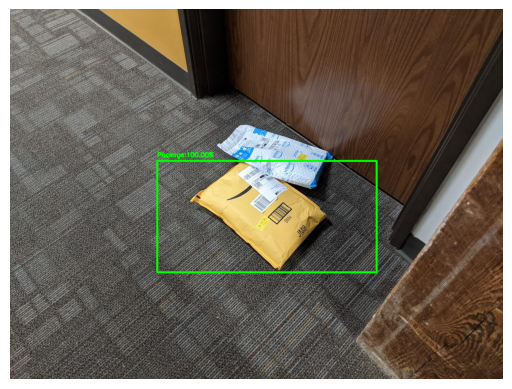

In [13]:
# Test image part
test_image_part = r"C:\Users\jinny\Desktop\cv\Package dataset\test\PXL_20201103_181916758_jpg.rf.143b472aca26adaf77dbc094c9b1fa3b.jpg"

#Preprocess test image from your drive
img_org, img_input, (h, w) = preprocess_image(test_image_part)

# Predict boundingbox and class label
pred_bbox, pred_class = model.predict(img_input[np.newaxis, ...])
# Bounding box (normalized → pixel)

pred_bbox = pred_bbox[0]
pred_class = pred_class[0]

xmin = int(pred_bbox[0] * w)
ymin = int(pred_bbox[1] * h)
xmax = int(pred_bbox[2] * w)
ymax = int(pred_bbox[3] * h)

# Draw rectangle from predict bbox
cv2.rectangle(
    img_org,
    (xmin, ymin),
    (xmax, ymax),
    (0, 255, 0),
    3
)

# Class prediction
class_id = np.argmax(pred_class)
class_name = list(class_map.keys())[class_id]
confidence = pred_class[class_id] * 100


# Put the class name and confidence on the bbox
pred_label = f"{class_name}:{confidence:.2f}%"
cv2.putText(
    img_org,
    pred_label,
    (xmin, ymin - 10),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.5,
    (0, 255, 0),
    2
)
# Display the image with bounding box and label
import matplotlib.pyplot as plt
plt.imshow(img_org)
plt.axis("off")
plt.show()